In [2]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-11-12 13:46:39--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2025-11-12 13:46:40 (218 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [4]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})
df_books.head()


,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


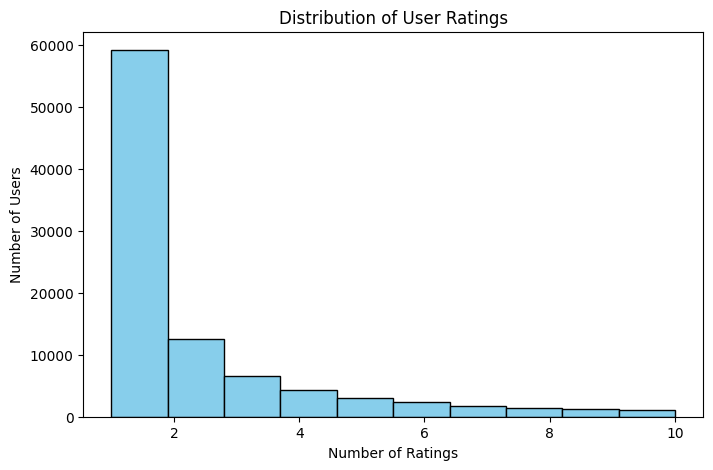

In [6]:
user_counts=df_ratings['user'].value_counts()
plt.figure(figsize=(8,5))
plt.hist(user_counts[user_counts <= 10],bins=10,color='skyblue',edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Distribution of User Ratings')
plt.show()

In [7]:
book_rating_count=df_ratings['isbn'].value_counts().reset_index()
book_rating_count.columns=['isbn','num_ratings']
book_rating_count.head()

,isbn,num_ratings
0,0971880107,2502
1,0316666343,1295
2,0385504209,883
3,0060928336,732
4,0312195516,723


In [8]:
#Merge to get book titles
book_rating_count = pd.merge(book_rating_count, df_books, on='isbn', how='left',suffixes=('', '_book'))
#Clean titles (replace NaN or non-string)
book_rating_count['title'] = book_rating_count['title'].fillna('Unknown Title').astype(str)
book_rating_count.head()

,isbn,num_ratings,title,author
0,0971880107,2502,Wild Animus,Rich Shapero
1,0316666343,1295,The Lovely Bones: A Novel,Alice Sebold
2,0385504209,883,The Da Vinci Code,Dan Brown
3,0060928336,732,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
4,0312195516,723,The Red Tent (Bestselling Backlist),Anita Diamant


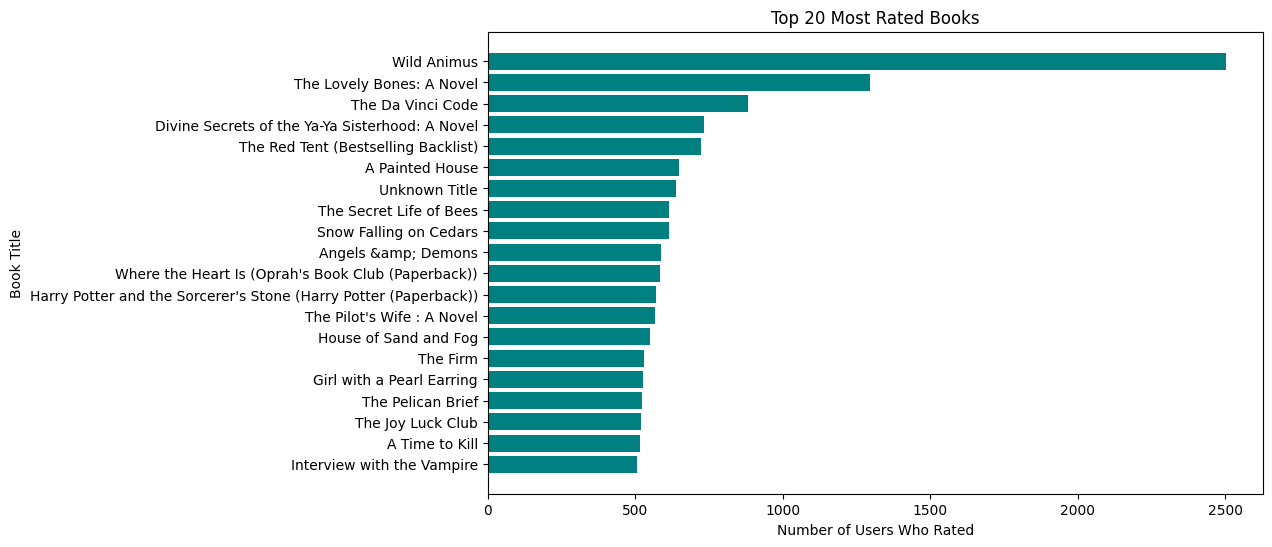

In [9]:
#Select top 20 most rated books
top_books = book_rating_count.sort_values('num_ratings', ascending=False).head(20)

#Plot bar graph
plt.figure(figsize=(10,6))
plt.barh(top_books['title'], top_books['num_ratings'], color='teal')
plt.gca().invert_yaxis()  # show most rated book at the top
plt.xlabel('Number of Users Who Rated')
plt.ylabel('Book Title')
plt.title('Top 20 Most Rated Books')
plt.show()


In [10]:
#filter out users with fewer than 200 ratings
active_users=df_ratings['user'].value_counts()>=200
active_user_ids=active_users[active_users].index
df_ratings=df_ratings[df_ratings['user'].isin(active_user_ids)]

#filter out books with fewer than 100 ratings
popular_books=df_ratings['isbn'].value_counts()>=100
popular_book_ids=popular_books[popular_books].index
df_ratings=df_ratings[df_ratings['isbn'].isin(popular_book_ids)]

In [11]:
# Merge df_ratings with df_books to get book titles
df_ratings = pd.merge(df_ratings, df_books, on='isbn', how='left', suffixes=('', '_book'))

# Create the pivot table (books × users)
book_user_matrix = df_ratings.pivot_table(
    index='title',
    columns='user',
    values='rating'
).fillna(0)

# convert to sparse matrix
book_user_sparse = csr_matrix(book_user_matrix.values)

In [12]:
model =NearestNeighbors(metric='cosine',algorithm='brute')
model.fit(book_user_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [13]:
def get_recommends(book=""):
    book_idx = book_user_matrix.index.get_loc(book)
    X_query = book_user_matrix.iloc[book_idx, :].values.reshape(1, -1)
    k = 6
    distances, indices = model.kneighbors(X_query, n_neighbors=k)

    recommended_books = []
    for i in range(1, len(distances.flatten())):
        recommended_books.append([
            book_user_matrix.index[indices.flatten()[i]],
            round(float(distances.flatten()[i]), 2)
        ])


    return [book,recommended_books]


In [19]:
def test_book_recommendation():
    recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

    # extract inner list properly
    rec_list = recommends[1]
    print("\nYour recommendations:")
    for r in rec_list:
        print(f"{r[0]} — {round(r[1],2)}")

test_book_recommendation()



Your recommendations:
The Lovely Bones: A Novel — 0.72
The Pilot's Wife : A Novel — 0.82
The Joy Luck Club — 0.82
The Notebook — 0.82
Bel Canto: A Novel — 0.82
